# Libraries & Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [4]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [5]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [6]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')
df_sub = pd.read_csv('/kaggle/input/playground-series-s5e11/sample_submission.csv')

# EDA

In [7]:
df_train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [8]:
print('df_train.shape:', df_train.shape)
print('df_test.shape:', df_test.shape)

df_train.shape: (593994, 13)
df_test.shape: (254569, 12)


In [9]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB
None


In [10]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254569 entries, 0 to 254568
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    254569 non-null  int64  
 1   annual_income         254569 non-null  float64
 2   debt_to_income_ratio  254569 non-null  float64
 3   credit_score          254569 non-null  int64  
 4   loan_amount           254569 non-null  float64
 5   interest_rate         254569 non-null  float64
 6   gender                254569 non-null  object 
 7   marital_status        254569 non-null  object 
 8   education_level       254569 non-null  object 
 9   employment_status     254569 non-null  object 
 10  loan_purpose          254569 non-null  object 
 11  grade_subgrade        254569 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 23.3+ MB
None


### No nulls exist.

In [11]:
print(df_train.describe())

                  id  annual_income  debt_to_income_ratio   credit_score  \
count  593994.000000  593994.000000         593994.000000  593994.000000   
mean   296996.500000   48212.202976              0.120696     680.916009   
std    171471.442235   26711.942078              0.068573      55.424956   
min         0.000000    6002.430000              0.011000     395.000000   
25%    148498.250000   27934.400000              0.072000     646.000000   
50%    296996.500000   46557.680000              0.096000     682.000000   
75%    445494.750000   60981.320000              0.156000     719.000000   
max    593993.000000  393381.740000              0.627000     849.000000   

         loan_amount  interest_rate  loan_paid_back  
count  593994.000000  593994.000000   593994.000000  
mean    15020.297629      12.356345        0.798820  
std      6926.530568       2.008959        0.400883  
min       500.090000       3.200000        0.000000  
25%     10279.620000      10.990000        1.

In [12]:
cols = ['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back']

In [13]:
for col in cols:
    print(col, df_train[col].nunique())

id 593994
annual_income 119728
debt_to_income_ratio 526
credit_score 399
loan_amount 111570
interest_rate 1454
gender 3
marital_status 4
education_level 5
employment_status 5
loan_purpose 8
grade_subgrade 30
loan_paid_back 2


In [14]:
cat_cols = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
num_cols = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']

## Target Distribution Visualization

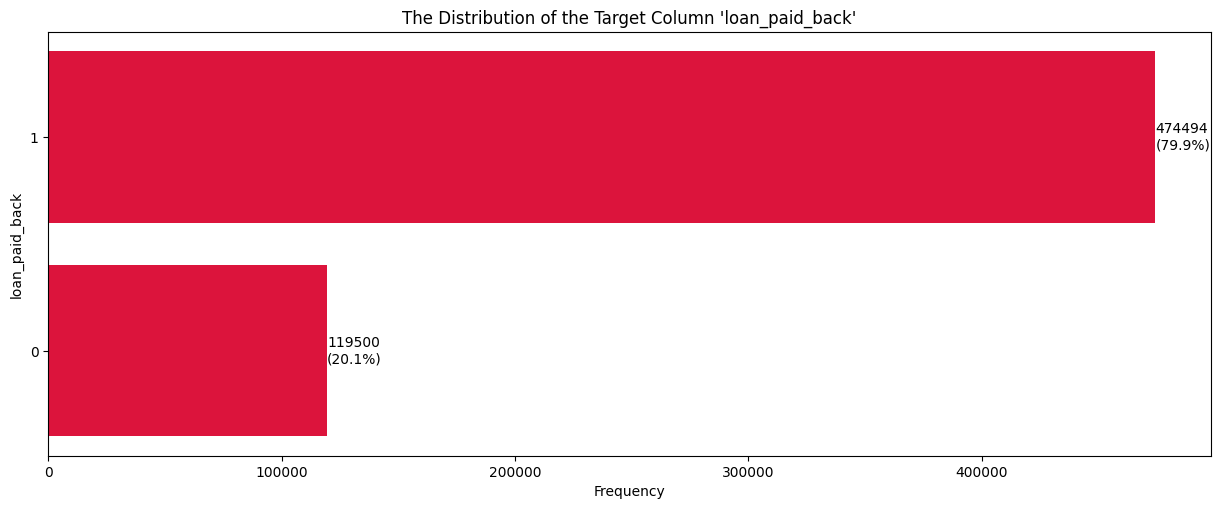

In [15]:
counts = df_train['loan_paid_back'].value_counts()
labels = counts.index
values = counts.values

plt.figure(figsize=(15,5.5)) 

bars = plt.barh(labels, values, color = 'crimson')
plt.ylabel("loan_paid_back")
plt.xlabel("Frequency")
plt.title("The Distribution of the Target Column 'loan_paid_back'")


plt.yticks([1, 0])

total = values.sum()
for bar, count in zip(bars, values):
    width = bar.get_width()
    pct = count / total * 100
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f"{count}\n({pct:.1f}%)",
             ha='left', va='center')
plt.show()

### pay off : default = 8 : 2

## Continuous Variable Distribution Visualization

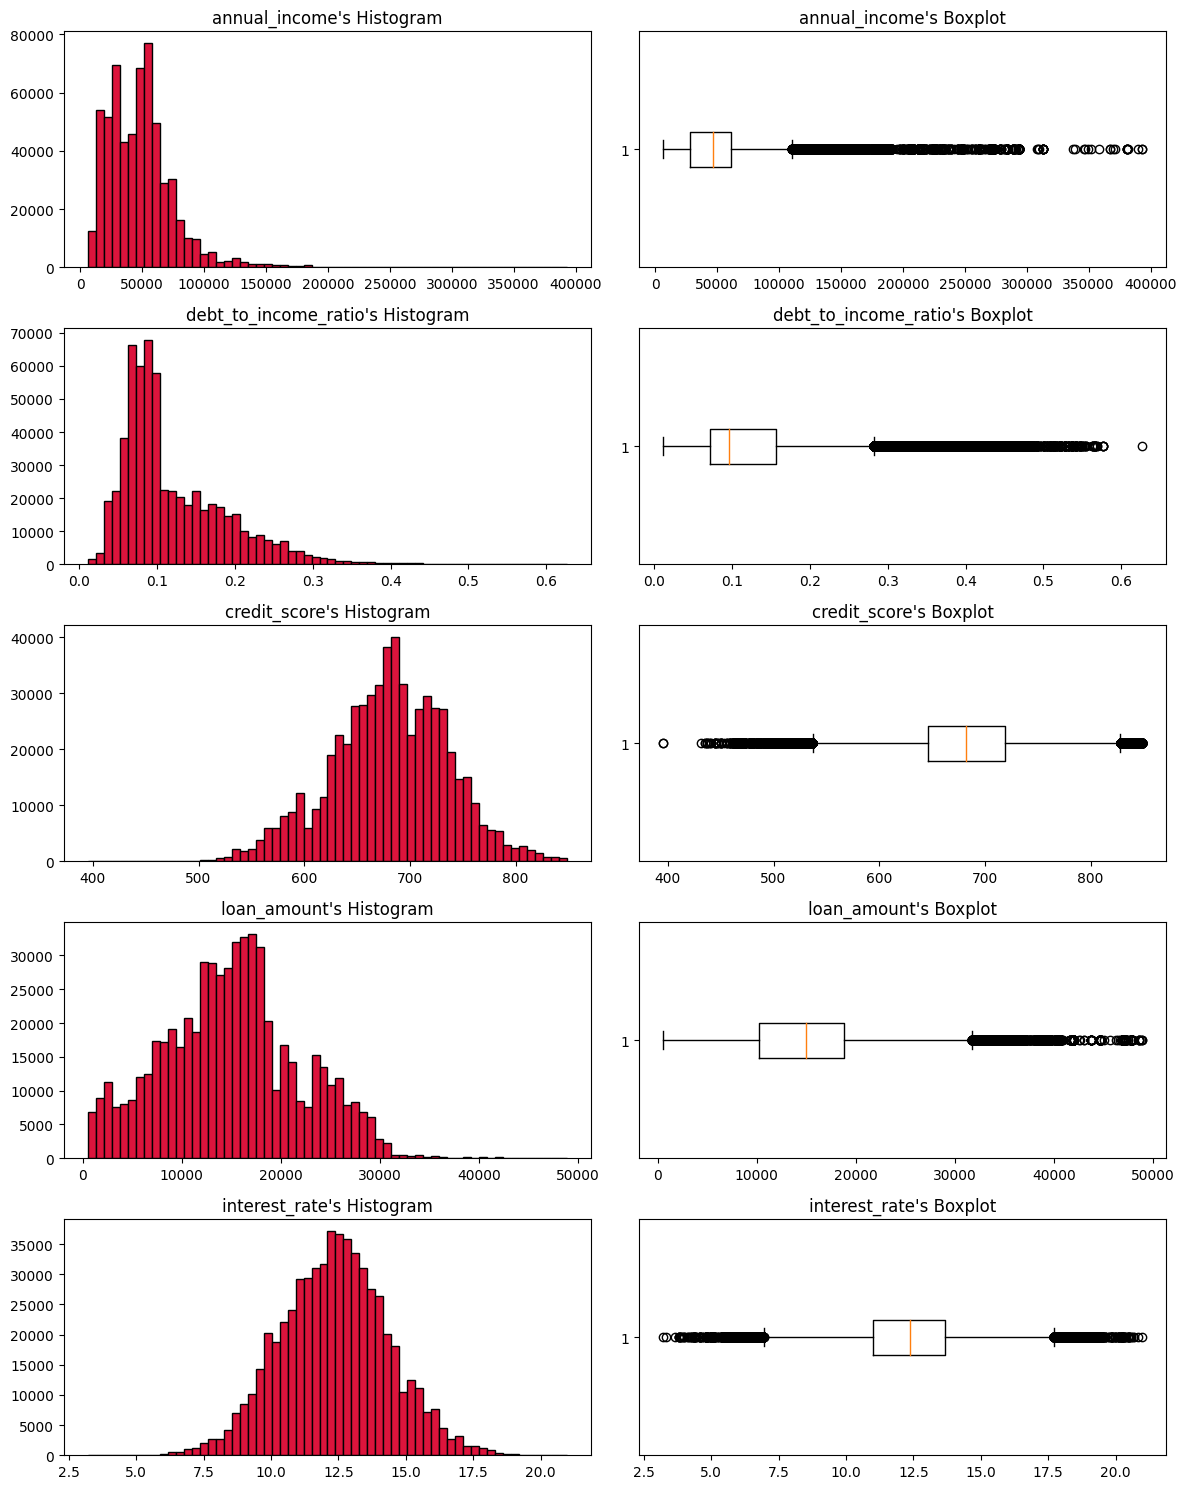

In [16]:
n_vars = len(num_cols)
fig, axes = plt.subplots(n_vars, 2, figsize=(12, n_vars * 3))

for i, col in enumerate(num_cols):

    axes[i, 0].hist(df_train[col], bins=60, edgecolor='black', color = 'crimson')
    axes[i, 0].set_title(f"{col}'s Histogram")
    
    axes[i, 1].boxplot(df_train[col], vert=False)
    axes[i, 1].set_title(f"{col}'s Boxplot")

plt.tight_layout()
plt.show()

### There seem to be many outliers.

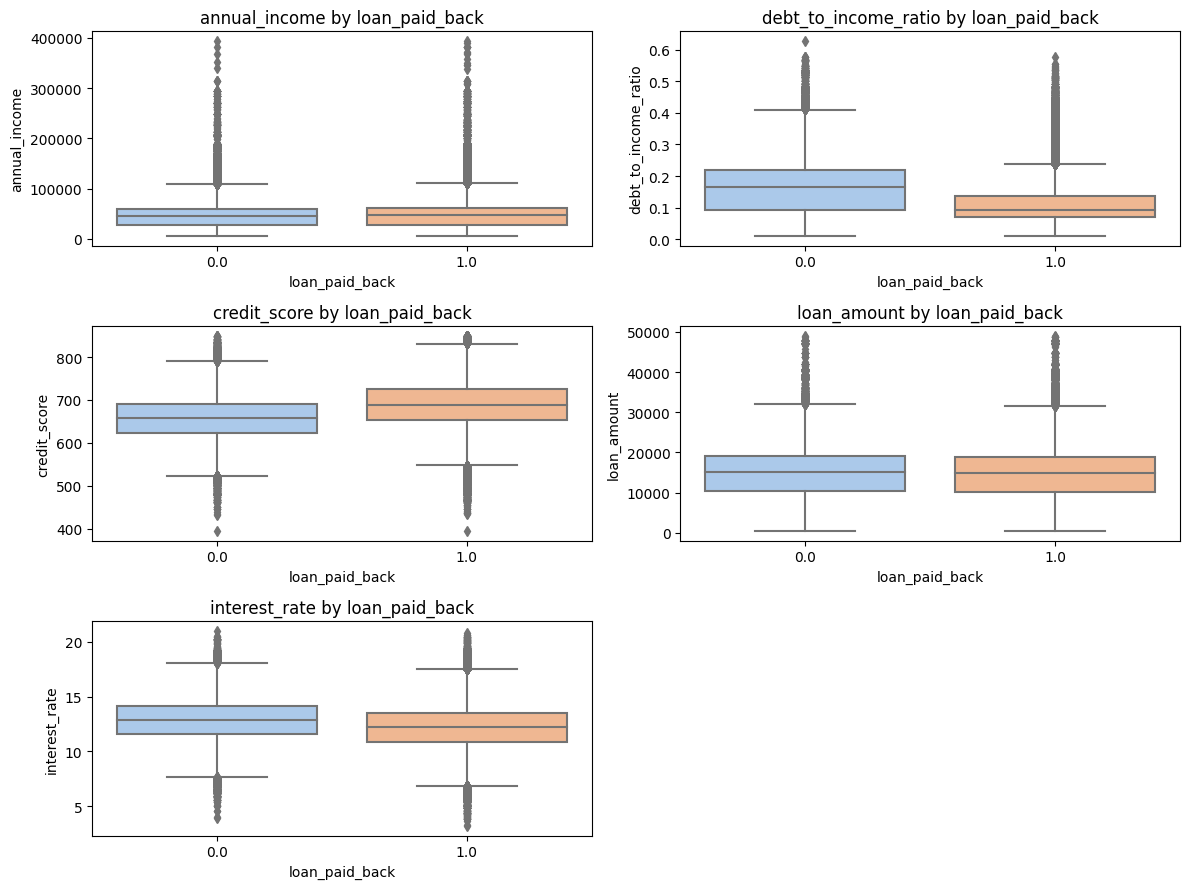

In [17]:
n_vars = len(num_cols)
n_cols = 2 
n_rows = (n_vars + 1) // 2  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows)) 

for i, col in enumerate(num_cols):
    row = i // 2  
    col_idx = i % 2  
    sns.boxplot(x='loan_paid_back', y=col, data=df_train, ax=axes[row, col_idx], palette='pastel')
    axes[row, col_idx].set_title(f"{col} by loan_paid_back")

if n_vars % 2 != 0:
    fig.delaxes(axes[n_rows-1, 1])

plt.tight_layout()
plt.show()

## Categorical Variable Distribution Visualization

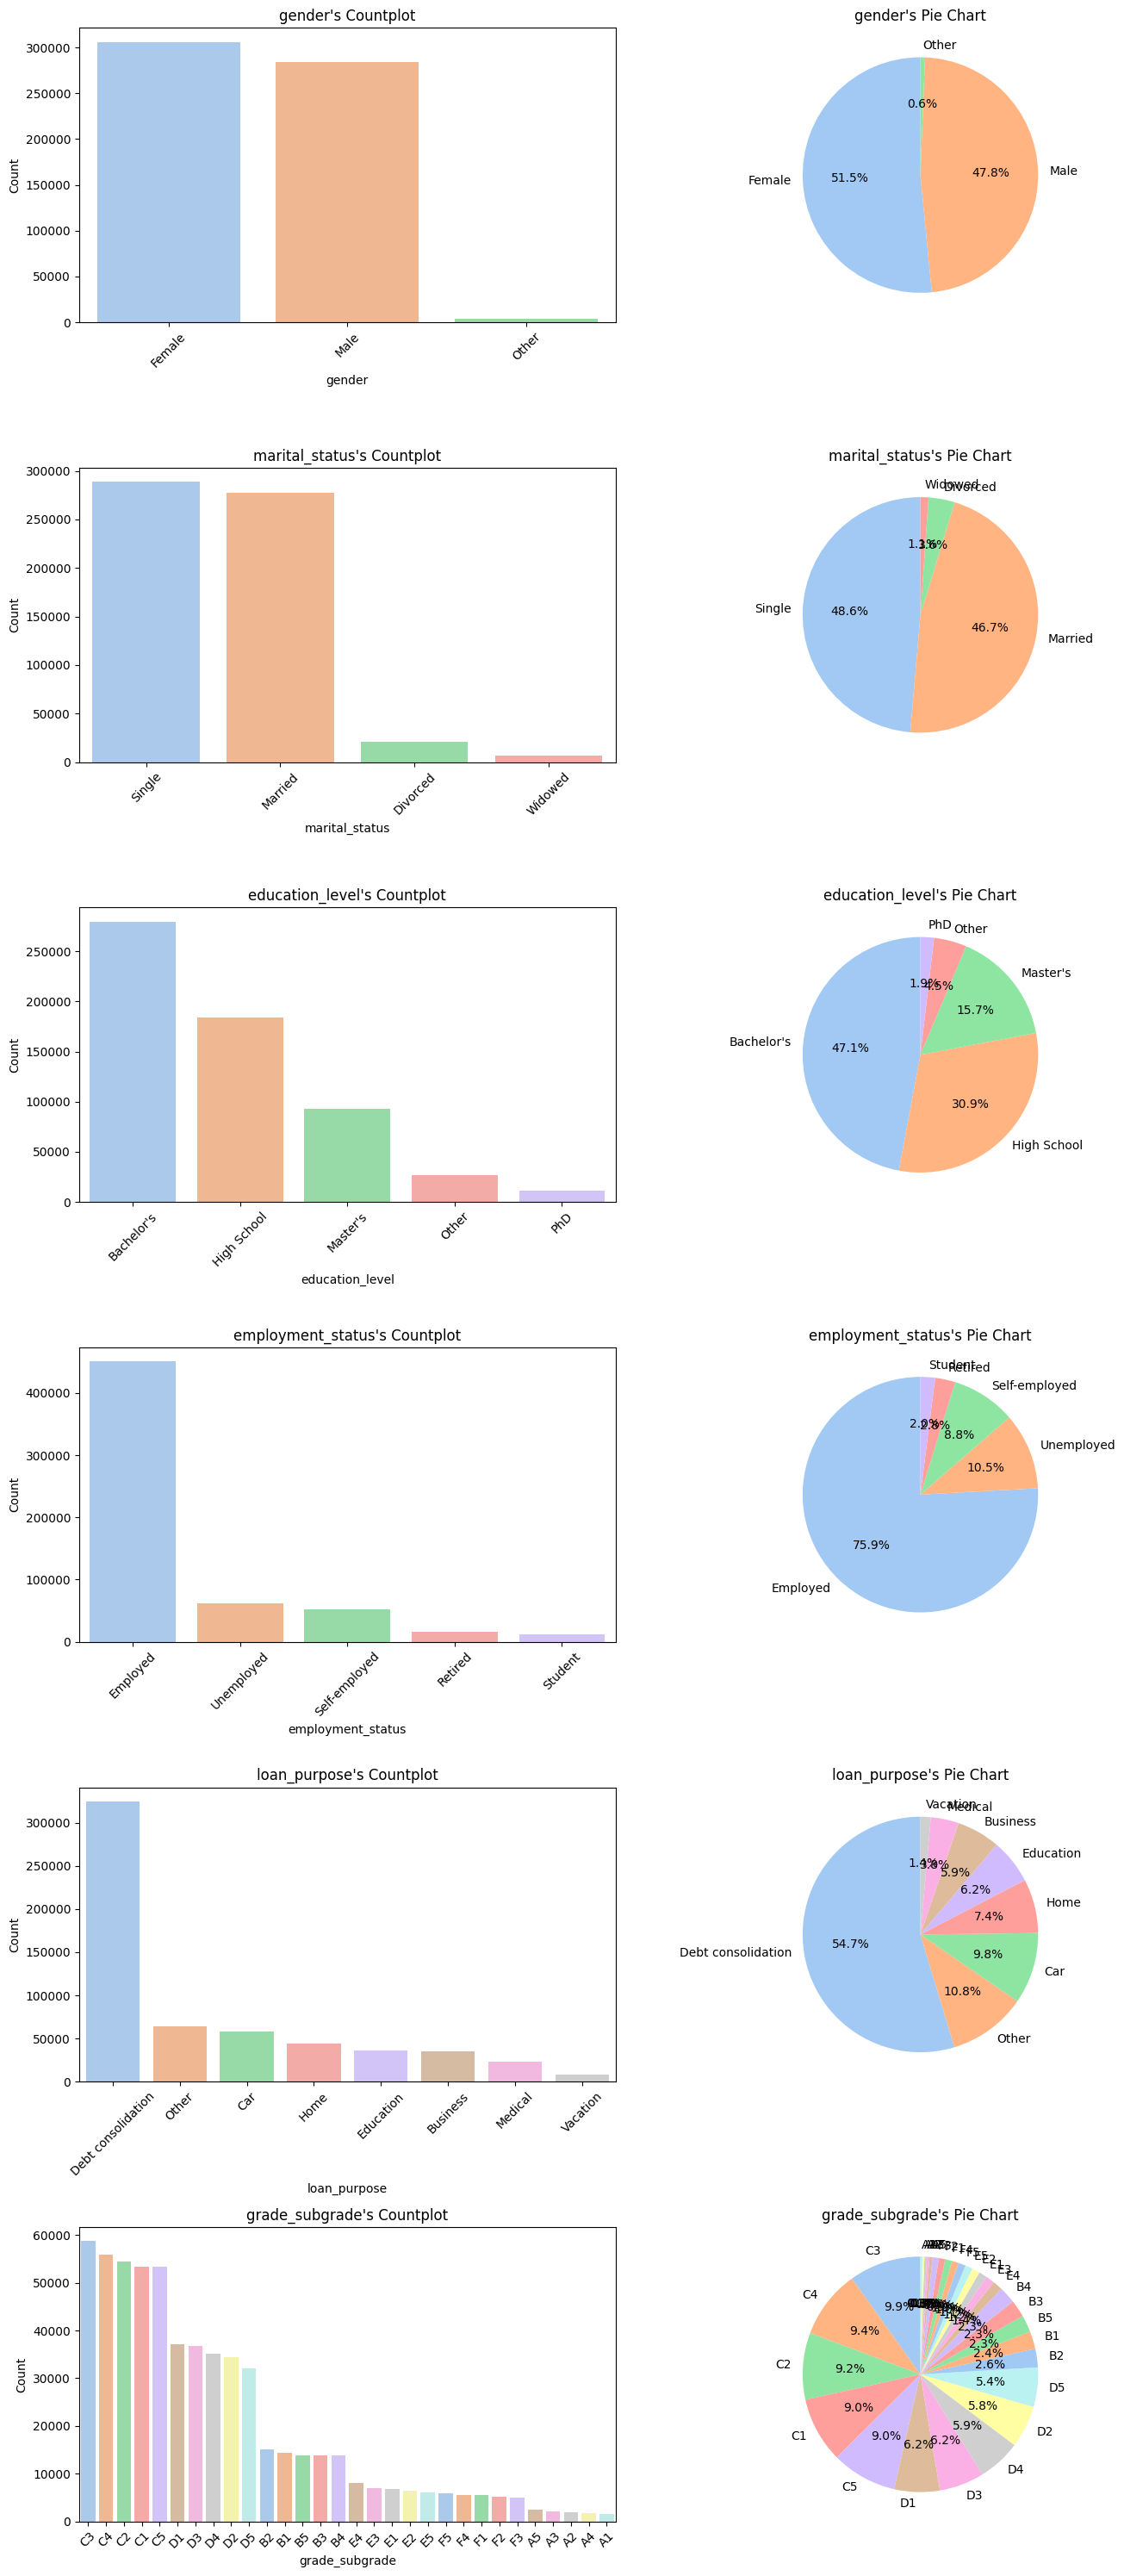

In [18]:
n_vars = len(cat_cols)
fig, axes = plt.subplots(n_vars, 2, figsize=(14, n_vars * 5))

for i, col in enumerate(cat_cols):
    sns.countplot(x=df_train[col], ax=axes[i, 0],
                  order=df_train[col].value_counts().index,
                  palette='pastel')
    axes[i, 0].set_title(f"{col}'s Countplot")
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')
    axes[i, 0].tick_params(axis='x', rotation=45)

    df_train[col].value_counts().plot.pie(
        ax=axes[i, 1],
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('pastel'),
        legend=False,
        ylabel='' 
    )
    axes[i, 1].set_title(f"{col}'s Pie Chart")

plt.tight_layout()
plt.show()

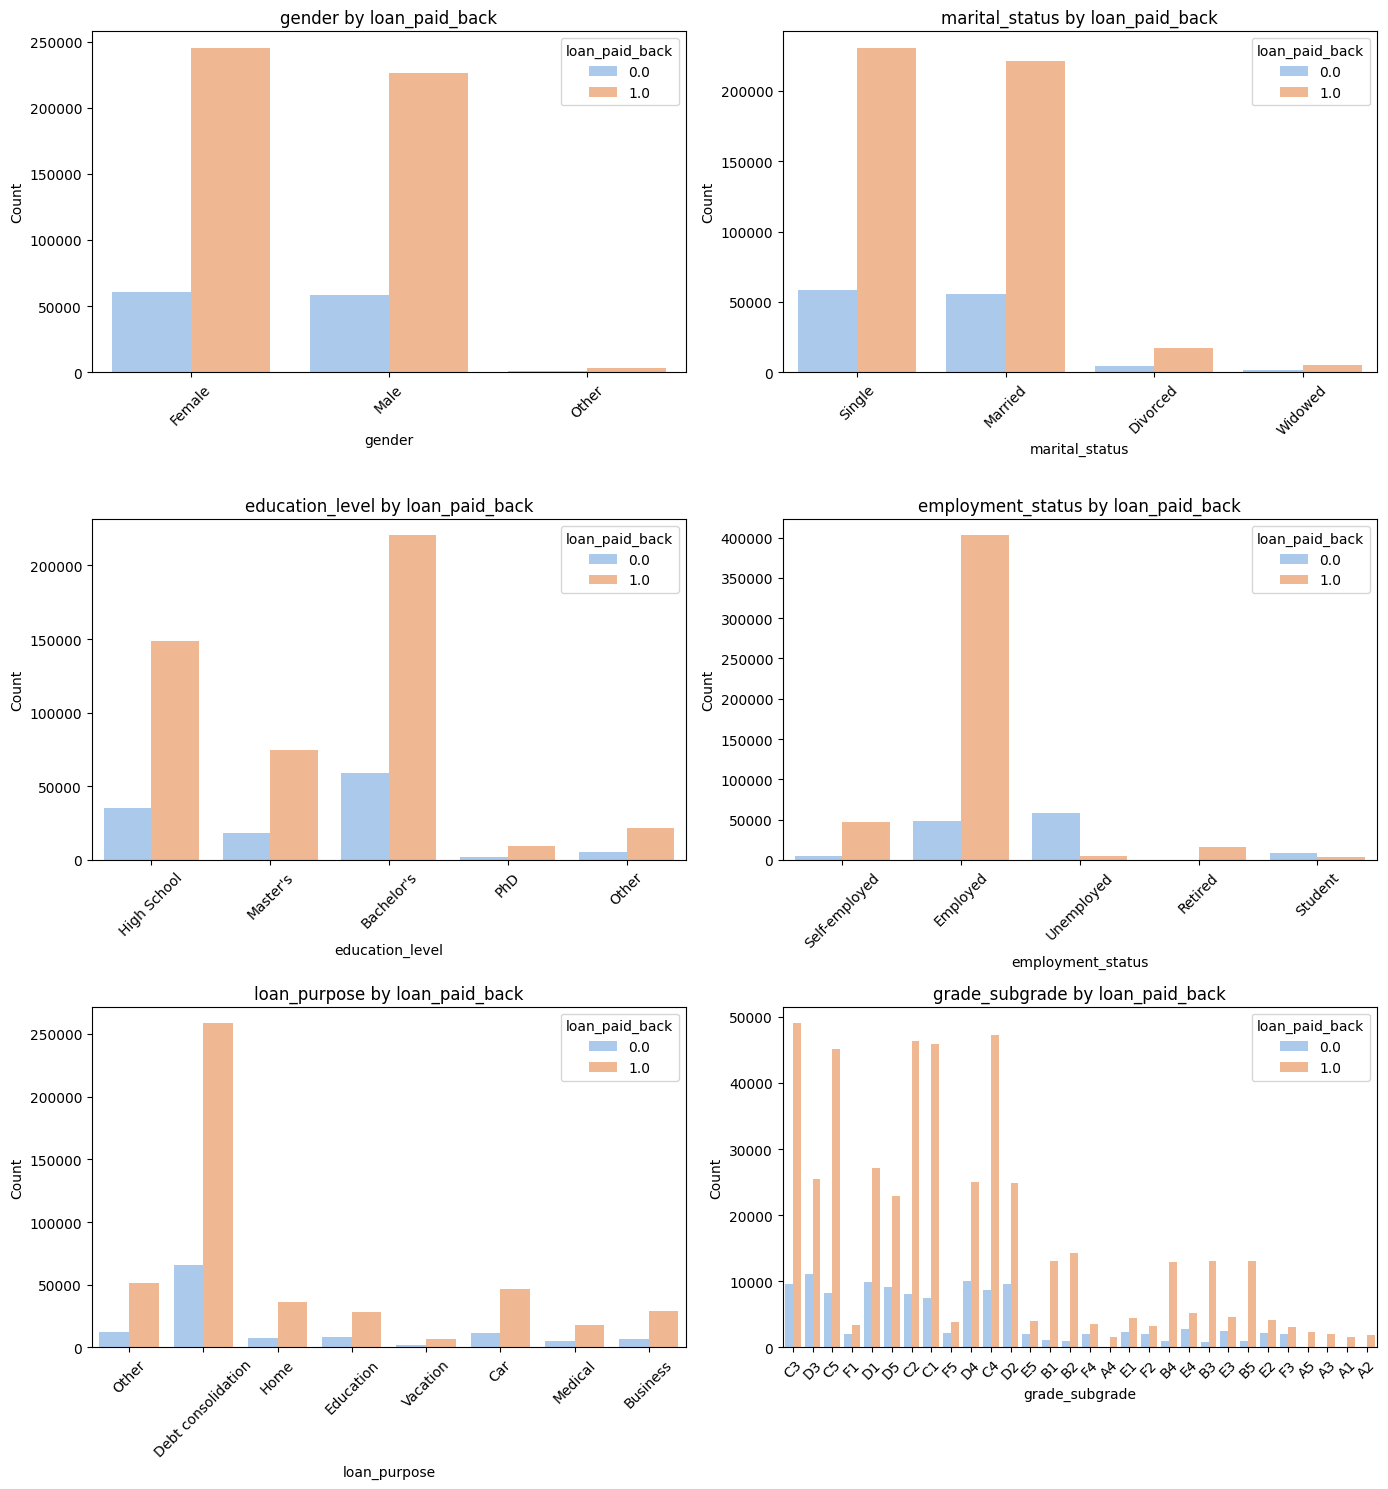

In [19]:
n_vars = len(cat_cols)
n_cols = 2
n_rows = (n_vars + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))

for i, col in enumerate(cat_cols):
    row = i // 2
    col_idx = i % 2
    sns.countplot(x=col, hue='loan_paid_back', data=df_train, ax=axes[row, col_idx], palette='pastel')
    axes[row, col_idx].set_title(f"{col} by loan_paid_back")
    axes[row, col_idx].tick_params(axis='x', rotation=45)
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Count')

if n_vars % 2 != 0:
    fig.delaxes(axes[n_rows - 1, 1])

plt.tight_layout()
plt.show()

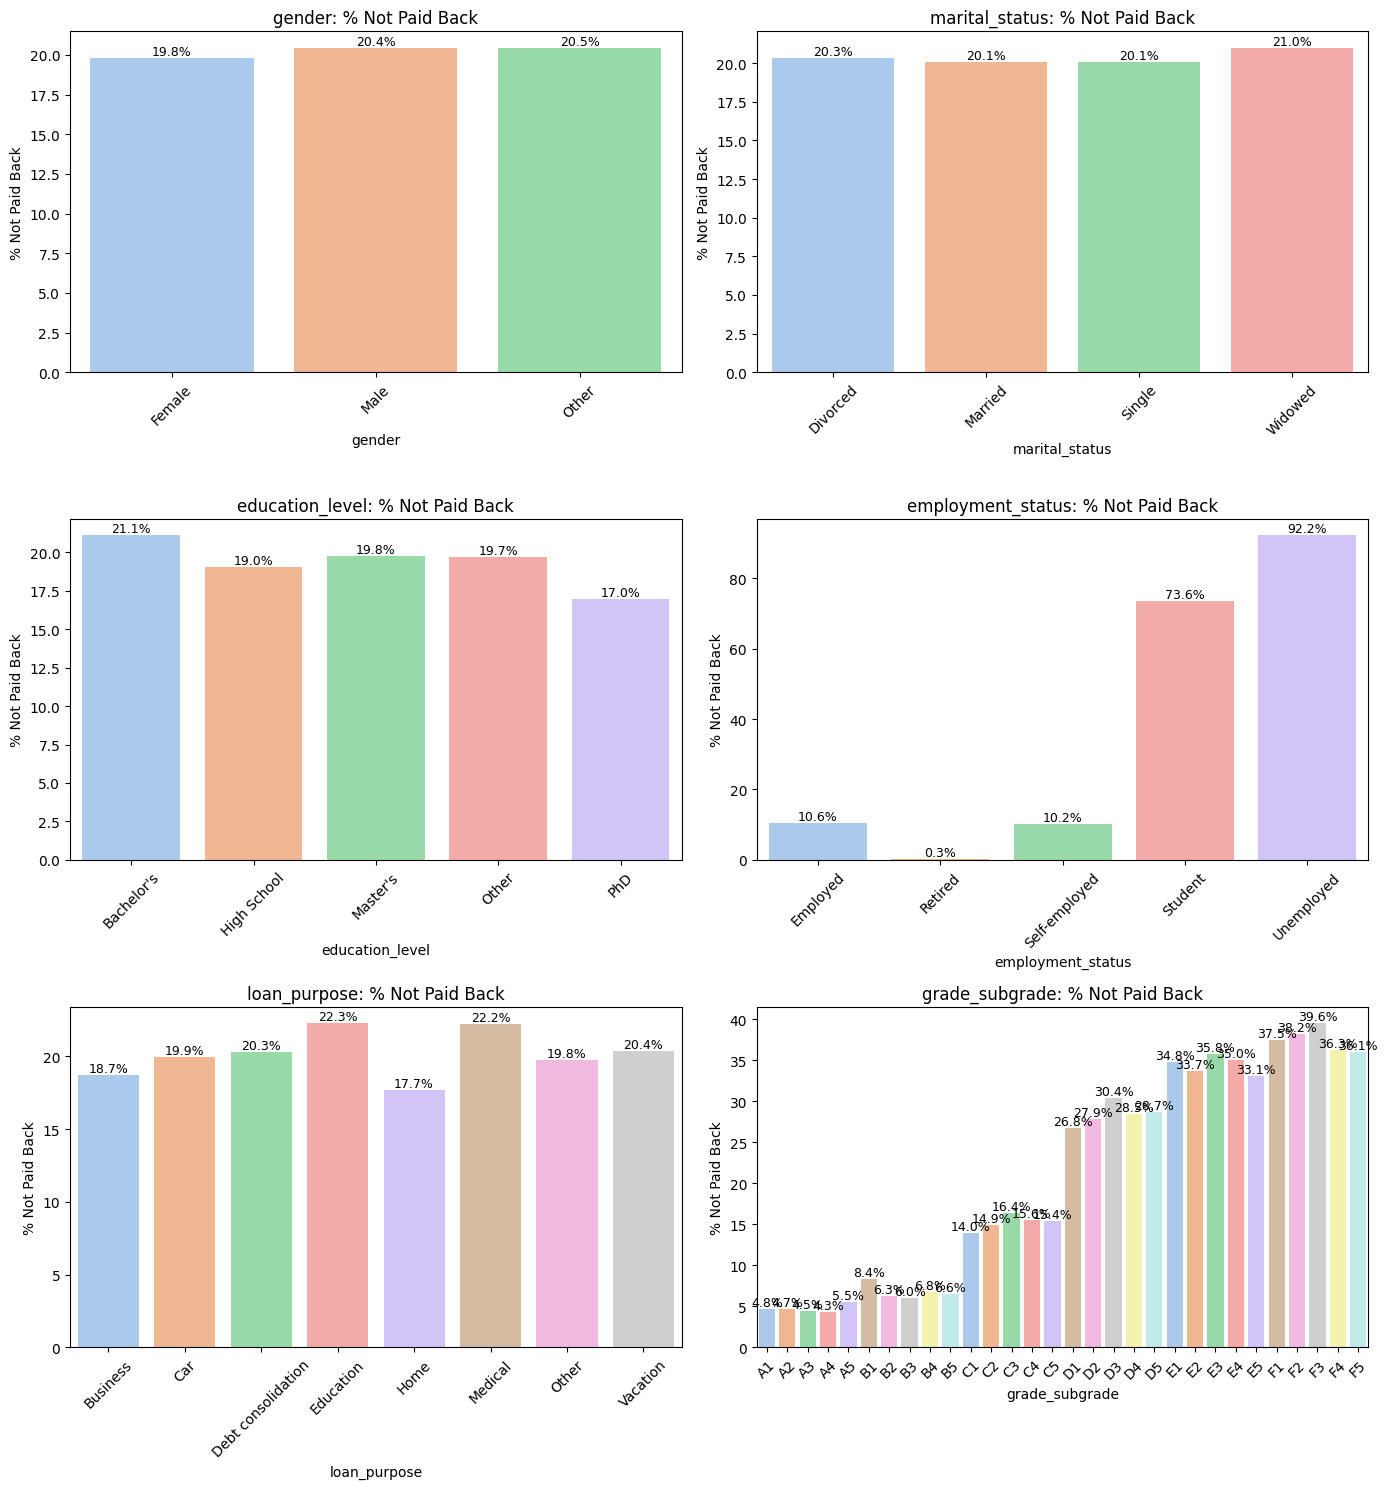

In [20]:
n_vars = len(cat_cols)
n_cols = 2
n_rows = (n_vars + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))

for i, col in enumerate(cat_cols):
    row = i // 2
    col_idx = i % 2

    ratio = (
        df_train.groupby(col)['loan_paid_back']
        .value_counts(normalize=True)
        .rename('ratio')
        .mul(100)
        .reset_index()
    )

    ratio = ratio[ratio['loan_paid_back'] == 0]

    sns.barplot(
        data=ratio,
        x=col,
        y='ratio',
        ax=axes[row, col_idx],
        palette='pastel'
    )

    axes[row, col_idx].set_title(f"{col}: % Not Paid Back")
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('% Not Paid Back')
    axes[row, col_idx].tick_params(axis='x', rotation=45)
    axes[row, col_idx].bar_label(axes[row, col_idx].containers[0], fmt='%.1f%%', label_type='edge', fontsize=9)

if n_vars % 2 != 0:
    fig.delaxes(axes[n_rows - 1, 1])

plt.tight_layout()
plt.show()

### On average, 20.1% of borrowers failed to repay their loans. Features that showed moderate deviations from this average were **education** and **loan purpose**, while those with large deviations were **employment status** and **grade_subgrade**.


# Preprocessing

In [21]:
def remove_outliers(df, cols):
    
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        
    return df

In [22]:
df_train = remove_outliers(df_train, num_cols)

In [23]:
def feature_engineering(df):
    
    # 1. employment_status & grade_subgrade
    df["employment_status_grade_subgrade"] = df["employment_status"].astype(str) + "_" + df["grade_subgrade"].astype(str)
    
    # 2. interest_rate / debt_to_income_ratio
    df["interest_rate_to_dti"] = df["interest_rate"] / (df["debt_to_income_ratio"] + 1e-6)
    
    # 3. education_level & loan_purpose
    df["education_loan_purpose"] = df["education_level"].astype(str) + "_" + df["loan_purpose"].astype(str)
    
    # 4. employment_status & loan_purpose
    df["employment_loan_purpose"] = df["employment_status"].astype(str) + "_" + df["loan_purpose"].astype(str)
    
    # 5. education_level & grade_subgrade
    df["education_grade_subgrade"] = df["education_level"].astype(str) + "_" + df["grade_subgrade"].astype(str)
    
    return df

In [24]:
df_train = feature_engineering(df_train)

In [25]:
df_test = feature_engineering(df_test)

In [26]:
df_train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,employment_status_grade_subgrade,interest_rate_to_dti,education_loan_purpose,employment_loan_purpose,education_grade_subgrade
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0,Self-employed_C3,162.736158,High School_Other,Self-employed_Other,High School_C3
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0,Employed_D3,77.830856,Master's_Debt consolidation,Employed_Debt consolidation,Master's_D3
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0,Employed_C5,100.617519,High School_Debt consolidation,Employed_Debt consolidation,High School_C5
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0,Employed_D1,192.637875,High School_Other,Employed_Other,High School_D1
5,5,44940.30,0.058,653,12159.92,12.24,Male,Single,Bachelor's,Employed,Other,D1,1.0,Employed_D1,211.030844,Bachelor's_Other,Employed_Other,Bachelor's_D1


In [27]:
df_test.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,employment_status_grade_subgrade,interest_rate_to_dti,education_loan_purpose,employment_loan_purpose,education_grade_subgrade
0,593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5,Employed_D5,300.606110,High School_Other,Employed_Other,High School_D5
1,593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1,Employed_C1,138.170557,Master's_Other,Employed_Other,Master's_C1
2,593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1,Employed_D1,36.212435,Bachelor's_Debt consolidation,Employed_Debt consolidation,Bachelor's_D1
3,593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3,Employed_C3,86.999209,Bachelor's_Debt consolidation,Employed_Debt consolidation,Bachelor's_C3
4,593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1,Employed_C1,158.022740,PhD_Business,Employed_Business,PhD_C1


# Modeling

In [28]:
rs = 42

In [29]:
def prepare_data(df_train, target_col, num_cols, cat_cols):
    
    X = df_train.drop(columns=[target_col])
    y = df_train[target_col]
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=rs)
    
    onehot_cols = ['gender', 'marital_status', 'loan_purpose']
    ordinal_cols = ['education_level', 'employment_status', 'grade_subgrade']
    
    num_transformer = StandardScaler()
    onehot_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ordinal_transformer = OrdinalEncoder()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('onehot', onehot_transformer, onehot_cols),
            ('ordinal', ordinal_transformer, ordinal_cols)
        ],
        remainder='drop'  
    )
    
    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)
    
    return X_train_processed, X_val_processed, y_train, y_val, preprocessor

In [30]:
def optimize_models(X_train, y_train):
    def objective(trial):
        model_type = trial.suggest_categorical("model", ["logistic", "lgbm", "xgb"])
        
        if model_type == "logistic":
            C = trial.suggest_float("C", 1e-3, 10.0, log=True)
            model = LogisticRegression(C=C, solver='lbfgs', max_iter=1000, random_state=rs)
        
        elif model_type == "lgbm":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 800),
                "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.05, log=True),
                "num_leaves": trial.suggest_int("num_leaves", 31, 255),
                "max_depth": trial.suggest_int("max_depth", 4, 15),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
                "random_state": rs,
                "verbose": -1,
            }
            model = lgb.LGBMClassifier(**params)
        
        else:  # XGBoost
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 800),
                "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.05, log=True),
                "max_depth": trial.suggest_int("max_depth", 3, 12),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
                "gamma": trial.suggest_float("gamma", 0.0, 1.0),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
                "random_state": rs,
                "use_label_encoder": False,
                "eval_metric": "auc"
            }
            model = xgb.XGBClassifier(**params)
        
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rs)
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
        return np.mean(scores)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)
    
    print("\nBest trial:")
    print(study.best_trial.params)
    return study.best_trial.params

In [31]:
def create_models_with_optuna(X_train, y_train, model_type):
    best_params = optimize_models(X_train, y_train)
    model_type = best_params.pop("model")

    if model_type == "logistic":
        model = LogisticRegression(**best_params, solver='lbfgs', max_iter=1000, random_state=rs)
    elif model_type == "lgbm":
        model = lgb.LGBMClassifier(**best_params)
    else:
        model = xgb.XGBClassifier(**best_params)
    
    print(f"\n✅ Selected model: {model_type}")
    return model

In [32]:
def ensemble_predict(models, X):
    lr_model, lgb_model, xgb_model = models
    
    lr_pred = lr_model.predict_proba(X)[:, 1]
    lgb_pred = lgb_model.predict_proba(X)[:, 1]
    xgb_pred = xgb_model.predict_proba(X)[:, 1]
    
    ensemble_pred_proba = np.mean([lr_pred, lgb_pred, xgb_pred], axis=0)
    ensemble_pred = (ensemble_pred_proba >= 0.5).astype(float)
    
    return ensemble_pred, ensemble_pred_proba

In [33]:
def main(df_train, target_col, num_cols, cat_cols):
    X_train_processed, X_val_processed, y_train, y_val, preprocessor = prepare_data(df_train, target_col, num_cols, cat_cols)
        
    print("🔍 Optimizing models with Optuna...")
    lr_model = create_models_with_optuna(X_train_processed, y_train, model_type="logistic")
    lgb_model = create_models_with_optuna(X_train_processed, y_train, model_type="lgbm")
    xgb_model = create_models_with_optuna(X_train_processed, y_train, model_type="xgb")

    print("Training optimized models...")
    lr_model.fit(X_train_processed, y_train)
    lgb_model.fit(X_train_processed, y_train)
    xgb_model.fit(X_train_processed, y_train)
    
    models = {'Logistic Regression': lr_model, 
              'LightGBM': lgb_model, 
              'XGBoost': xgb_model}
    
    for name, model in models.items():
        pred = model.predict(X_val_processed)
        proba = model.predict_proba(X_val_processed)[:, 1]
        acc = accuracy_score(y_val, pred)
        auc = roc_auc_score(y_val, proba)
        print(f"{name} - Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    
    ensemble_pred, ensemble_pred_proba = ensemble_predict([lr_model, lgb_model, xgb_model], X_val_processed)
    
    ensemble_acc = accuracy_score(y_val, ensemble_pred)
    ensemble_auc = roc_auc_score(y_val, ensemble_pred_proba)
    print(f"\nEnsemble - Accuracy: {ensemble_acc:.4f}, AUC: {ensemble_auc:.4f}")
    
    return preprocessor, lr_model, lgb_model, xgb_model

# Prediction & Submission

In [34]:
if __name__ == "__main__":

    df_train = df_train
    df_test = df_test
    df_sub = df_sub
    
    num_cols = num_cols
    target_col = 'loan_paid_back'
    cat_cols = cat_cols
    
    preprocessor, lr_model, lgb_model, xgb_model = main(df_train, target_col, num_cols, cat_cols)

    
    X_test_final_processed = preprocessor.transform(df_test)
    
    _, y_pred_ensemble = ensemble_predict(
        [lr_model, lgb_model, xgb_model], 
        X_test_final_processed
    )
    
    submission = pd.DataFrame({
        'id': df_sub['id'],
        'loan_paid_back': y_pred_ensemble
    })
    submission.to_csv('submission_ensemble.csv', index=False)
    
    df_confirm = pd.read_csv('submission_ensemble.csv')
    print(df_confirm.head())

[I 2025-11-12 02:19:31,093] A new study created in memory with name: no-name-9e643d71-66e5-4047-9fa6-544dbdcbf051


🔍 Optimizing models with Optuna...


[I 2025-11-12 02:20:14,261] Trial 0 finished with value: 0.9146619983783132 and parameters: {'model': 'lgbm', 'n_estimators': 414, 'learning_rate': 0.0024671026280554433, 'num_leaves': 208, 'max_depth': 15, 'subsample': 0.6814716895736814, 'colsample_bytree': 0.8722823459366158, 'reg_alpha': 0.04683132343122805, 'reg_lambda': 0.18943128064137726}. Best is trial 0 with value: 0.9146619983783132.
[I 2025-11-12 02:20:53,499] Trial 1 finished with value: 0.915622263116347 and parameters: {'model': 'xgb', 'n_estimators': 325, 'learning_rate': 0.002054789571328606, 'max_depth': 12, 'subsample': 0.9168557869076209, 'colsample_bytree': 0.6419422040444133, 'min_child_weight': 6, 'gamma': 0.5493737289797365, 'reg_alpha': 0.05480212453148368, 'reg_lambda': 0.0026936448532186934}. Best is trial 1 with value: 0.915622263116347.
[I 2025-11-12 02:21:41,322] Trial 2 finished with value: 0.9141246440203376 and parameters: {'model': 'xgb', 'n_estimators': 669, 'learning_rate': 0.004834123502839676, 'max


Best trial:
{'model': 'lgbm', 'n_estimators': 649, 'learning_rate': 0.03465693759335248, 'num_leaves': 66, 'max_depth': 12, 'subsample': 0.6247768668403502, 'colsample_bytree': 0.5020319622871697, 'reg_alpha': 0.39672521318345005, 'reg_lambda': 7.68237545874806}

✅ Selected model: lgbm


[I 2025-11-12 02:51:48,385] Trial 0 finished with value: 0.9183652809357757 and parameters: {'model': 'xgb', 'n_estimators': 419, 'learning_rate': 0.033970407768186696, 'max_depth': 7, 'subsample': 0.9466834424739308, 'colsample_bytree': 0.6670517321396818, 'min_child_weight': 7, 'gamma': 0.4941907487730267, 'reg_alpha': 1.1314646920900098, 'reg_lambda': 4.490690754443007}. Best is trial 0 with value: 0.9183652809357757.
[I 2025-11-12 02:51:52,960] Trial 1 finished with value: 0.8897633787430371 and parameters: {'model': 'logistic', 'C': 5.527990490822544}. Best is trial 0 with value: 0.9183652809357757.
[I 2025-11-12 02:52:43,323] Trial 2 finished with value: 0.9132357847068985 and parameters: {'model': 'lgbm', 'n_estimators': 601, 'learning_rate': 0.0010082657787685676, 'num_leaves': 110, 'max_depth': 8, 'subsample': 0.9708421121822338, 'colsample_bytree': 0.6855852789991517, 'reg_alpha': 0.0018326871837211563, 'reg_lambda': 4.0237396895854145}. Best is trial 0 with value: 0.91836528


Best trial:
{'model': 'lgbm', 'n_estimators': 717, 'learning_rate': 0.015001440504085084, 'num_leaves': 249, 'max_depth': 12, 'subsample': 0.6674967058326573, 'colsample_bytree': 0.5014715857982545, 'reg_alpha': 1.2465712765445698, 'reg_lambda': 0.216522114188565}

✅ Selected model: lgbm


[I 2025-11-12 03:30:13,542] Trial 0 finished with value: 0.8897620804613214 and parameters: {'model': 'logistic', 'C': 0.1343423931179085}. Best is trial 0 with value: 0.8897620804613214.
[I 2025-11-12 03:30:41,130] Trial 1 finished with value: 0.9139406350285357 and parameters: {'model': 'xgb', 'n_estimators': 324, 'learning_rate': 0.00672573628144153, 'max_depth': 9, 'subsample': 0.6327421913552466, 'colsample_bytree': 0.9140308966335129, 'min_child_weight': 5, 'gamma': 0.49898865956621674, 'reg_alpha': 0.015681835065478114, 'reg_lambda': 0.011514237563021683}. Best is trial 1 with value: 0.9139406350285357.
[I 2025-11-12 03:31:05,336] Trial 2 finished with value: 0.9161521321546521 and parameters: {'model': 'lgbm', 'n_estimators': 436, 'learning_rate': 0.020912232070743008, 'num_leaves': 131, 'max_depth': 6, 'subsample': 0.7286464909953799, 'colsample_bytree': 0.9622749599470559, 'reg_alpha': 9.072345841574423, 'reg_lambda': 0.002714573148122407}. Best is trial 2 with value: 0.91615


Best trial:
{'model': 'lgbm', 'n_estimators': 703, 'learning_rate': 0.02167011747635103, 'num_leaves': 133, 'max_depth': 13, 'subsample': 0.7238416431174006, 'colsample_bytree': 0.5367013705519181, 'reg_alpha': 0.7587770638482858, 'reg_lambda': 2.760586808193526}

✅ Selected model: lgbm
Training optimized models...
[LightGBM] [Info] Number of positive: 355733, number of negative: 82470
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 438203, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.811800 -> initscore=1.461746
[LightGBM] [Info] Start training from score 1.461746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 355733, num